In [1]:
import numpy as np
import math
import networkx as nx
import matplotlib.pyplot as plt
from scipy.linalg import null_space

In [45]:
class SimplicialComplex:
    def __init__(self, all_simplices, is_sorted = False):
        # Ensure all simplices are represented with sorted tuples
        if not is_sorted:
            all_simplices = [tuple(sorted(simplex)) for simplex in all_simplices]
        # Check if the input is indeed forms a simplicial complex
        if not self._is_simplicial_complex(all_simplices):
            raise ValueError("The input set is not a valid simplicial complex.")
        # Initiate the complex data
        self.all_simplices = all_simplices
        # Dimension of the complex is defined to be the top-dimension of simplex
        # which is length - 1, e.g. (2, 3, 4) is a 2-simplex
        self.dimension = len(max(all_simplices, key=len))-1
        # Category simplices by its dimension
        self.dim_simplices = self._sort_simplices_by_dimension()

    def process_complex(self):
        # Flatten all simplices, make sure they are in a sorted order
        self.all_simplices = [simplex for dim in self.dim_simplices for simplex in dim]
        # Matrix algorithm to find persistence pairs
        self.incidence_matrices = self._build_incidence_matrix()
        self.reduced_incidence_matrices = self._build_reduced_incidence_matrix()
        self.finite_persistence_pairs = self._finite_persistence_pairs()
        self.infinite_persistence_pairs = self._infinite_persistence_pairs()
        # Find homology groups with Z2 coef, up to n-th homology
        self.homology = self._homology()

    def _sort_simplices_by_dimension(self):
        # Group and sort the simplices by dimension
        return [sorted([simplex for simplex in self.all_simplices if len(simplex) == i]) for i in range(1, self.dimension + 2)]
    
    def _is_simplicial_complex(self, all_simplices):
        # Check if the input is a valid simplicial complex
        # Iterate through each simplex in the set
        for simplex in all_simplices:
            if len(simplex) == 1:  # Single element, automatically valid
                continue
            # For higher dimensional simplices, check if all faces are present
            for i in range(len(simplex)):
                face = simplex[:i] + simplex[i+1:]  # Remove one element to get a face
                if face not in all_simplices:  # If the face is missing, it's invalid
                    return False
        return True
    
    def _build_incidence_matrix(self):
        # Find the boundary matrices in each dimension
        incidence_matrices = []
        for k_simplices, kp1_simplices in zip(self.dim_simplices, self.dim_simplices[1:]):
            incidence_matrix_k = np.zeros((len(k_simplices), len(kp1_simplices)), dtype = int)
            for simplex_index, simplex in enumerate(kp1_simplices):
                for i in range(len(simplex)):
                    face = tuple(simplex[:i] + simplex[i+1:])
                    face_index = k_simplices.index(face)
                    incidence_matrix_k[face_index, simplex_index] = 1
            incidence_matrices.append(incidence_matrix_k)
        return incidence_matrices

    def _build_reduced_incidence_matrix(self):

        def calculate_low_row_indices(matrix):
            # Low-row index of a column is defined to be the index of last occurrence of '1' in that column, or -1 if the column is full-0
            rows, cols = matrix.shape
            low_row_indices = []
            for col in range(cols):
                # Find the index of the last 1 in the column
                indices = np.where(matrix[:, col] == 1)[0]
                if len(indices) > 0:
                    low_row_indices.append(indices[-1])  # Last occurrence of 1
                else:
                    low_row_indices.append(-1)  # Mark columns with no 1s
            return low_row_indices

        def reduce_columns(matrix):
            rows, cols = matrix.shape
            def check_unique_without_negatives(lst):
                # Need to make sure no two columns have the same low-row indices, unless both are 0-columns
                filtered_lst = [x for x in lst if x != -1] # Filter out all -1s from the list
                # Check if the remaining elements are unique
                return len(filtered_lst) == len(set(filtered_lst))
            # Track and ensure unique low-row indices
            while(True):
                low_row_indices = calculate_low_row_indices(matrix)
                if check_unique_without_negatives(low_row_indices):
                    return matrix
                seen = {}
                for col in range(cols):
                    low_row = low_row_indices[col]
                    if low_row == -1:
                        continue  # Ignore columns with no 1s
                    if low_row not in seen:
                        seen[low_row] = col  # Store the first column with this low-row index
                    else:
                        # This is when two columns have the same low-row indices, that is, their last occurrence of 1 are on the same row
                        # In this case, add the first column to the second one, and take mod 2, this will force the second column to change its low-row index
                        # This operation may create a new repeated low-row index, that's the reason we need a while loop.
                        first_col = seen[low_row]
                        matrix[:, col] = (matrix[:, col] + matrix[:, first_col]) % 2

        reduced_incidence_matrices = []
        remove_list = []

        # Start with the last unreduced incidence matrix, reduce it
        for incidence_matrix in self.incidence_matrices[::-1]:
            # If a row is paired in previous matrix, we ignore it in the future calculation by setting the corresponding column 0
            # This is essentially because of that each simplex appears exactly once in persistence pairs
            incidence_matrix[:, remove_list] = 0
            incidence_matrix = reduce_columns(incidence_matrix)
            reduced_incidence_matrices.insert(0, incidence_matrix)

            low_row_indices = calculate_low_row_indices(incidence_matrix)
            remove_list = [index for index in low_row_indices if index != -1]
        return reduced_incidence_matrices

    def _finite_persistence_pairs(self):
        # The reduced incidence matrices will give us all the finite persistence pairs
        # In particular, for each k-dim reduced incidence matrix, the if the j-th column has low-row index i, then (i*, j*) is a persistence pair
        # Here, i* stands for the simplex (index) that corresponds to the i-th row, and j* stands for the simplex (index) that corresponds to the j-th column
        finite_persistence_pairs = []

        for dimension in range(len(self.reduced_incidence_matrices)):
            k_persistence_pairs = []
            reduced_incidence_matrix = self.reduced_incidence_matrices[dimension]
            rows, cols = reduced_incidence_matrix.shape
            for col in range(cols):
                indices = np.where(reduced_incidence_matrix[:, col] == 1)[0]
                if len(indices) > 0:
                    last_row = indices[-1]
                    birth_simplex_index = self.all_simplices.index(self.dim_simplices[dimension][last_row])
                    death_simplex_index = self.all_simplices.index(self.dim_simplices[dimension+1][col])
                    k_persistence_pairs.append((birth_simplex_index, death_simplex_index))
            finite_persistence_pairs.append(k_persistence_pairs)
        return finite_persistence_pairs
        
    def _infinite_persistence_pairs(self):
        # Infinite persistence pair are simply those simplices that have not appeared in finite persistence pairs, pairing with infinity
        # In particular, they are the homology classes that never die, and contribute to the overall homology group
        paired_simplices = {num for sublist in self.finite_persistence_pairs for tup in sublist for num in tup}
        all_simplices = set(range(len(self.all_simplices)))
        infinite_persistence_pairs = [(simplex, np.inf) for simplex in all_simplices - paired_simplices]
        return [sorted([pair for pair in infinite_persistence_pairs if len(self.all_simplices[pair[0]]) == i]) for i in range(1, self.dimension + 2)]

    def _homology(self):
        # Overall homology group is the count of infinite persistence pairs in that dimension
        homology = [0] * (self.dimension+1)
        infinite_persistence_pairs = [tup for sublist in self.infinite_persistence_pairs for tup in sublist]
        for infinite_persistence_pair in infinite_persistence_pairs:
            simplex = self.all_simplices[infinite_persistence_pair[0]]
            dimension = len(simplex) - 1
            homology[dimension] += 1
        return homology

class ChainComplex:
    def __init__(self, simplicial_complex):
        self.simplicial_complex = simplicial_complex
        self.boundary_ops = self._compute_boundary_ops()
        self.homology = self._compute_homology()

    def _compute_boundary_ops(self):
        # Compute boundary matrices for each dimension.
        dim_simplices = self.simplicial_complex.dim_simplices
        boundary_ops = []

        for k_simplices, kp1_simplices in zip(dim_simplices, dim_simplices[1:]):
            matrix = []
            for simplex in kp1_simplices:
                faces = [simplex[:i] + simplex[i+1:] for i in range(len(simplex))]
                matrix.append([
                    1 if simplex in faces and faces.index(simplex) % 2 == 0
                    else -1 if simplex in faces
                    else 0
                    for simplex in k_simplices
                ])
            boundary_ops.append(np.array(matrix).T)

        return boundary_ops

    def _compute_homology(self):
        # Calculate the homology groups from boundary matrices
        boundary_ops = self.boundary_ops.copy()
        # Add zero maps at the end
        mm = boundary_ops[-1].shape[1] if boundary_ops else 0
        boundary_ops.append(np.ones((mm, 0)))
        # Add zero maps at the begin
        nn = boundary_ops[0].shape[0] if boundary_ops else 0
        boundary_ops.insert(0, np.ones((0, nn)))

        homology_groups = []

        for k_boundary_ops, kp1_boundary_ops in zip(boundary_ops, boundary_ops[1:]):
            kappa = null_space(k_boundary_ops) #Kernel, perform SingularValueDecomposition and set threshold if not using scipy.
            psi, _, _, _ = np.linalg.lstsq(kappa, kp1_boundary_ops)
            ksi = null_space(psi.T) #Cokernel
            homology_groups.append(np.dot(kappa, ksi))
        
        return [group.shape[1] for group in homology_groups]

In [46]:
def bottleneck_distance(persistence_1, persistence_2):
    persistence_1 = [tup for sublist in persistence_1 for tup in sublist]
    persistence_2 = [tup for sublist in persistence_2 for tup in sublist]
    # Understand each pair as a point on xy-plane, find the closest point to it on the diagonal y = x
    closest_points_1 = [( (x + y) / 2, (x + y) / 2 ) for x, y in persistence_1]
    closest_points_2 = [( (x + y) / 2, (x + y) / 2 ) for x, y in persistence_2]
    # Put persistence_1 and closest_points_2, and persistence_2 and closest_points_1 together, respectively,
    # This way, they are ensured to have the same cardinality
    persistence_1 = persistence_1 + closest_points_2
    persistence_2 = persistence_2 + closest_points_1
    # Calculate all possible distance from a point in p1 to a point in p2
    distances = [math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2) for (x1, y1) in persistence_1 for (x2, y2) in persistence_2]
    # Sort the distances
    sorted_distances = sorted(distances)
    # Bottleneck distance algorithm
    lower_bound = 0
    upper_bound = len(sorted_distances) - 1
    while(lower_bound < upper_bound - 1):
        index = int(np.floor((upper_bound + lower_bound) / 2))
        threshold = sorted_distances[index]
        G = nx.Graph()
        # Add nodes for each element in persistence_1 and persistence_2
        G.add_nodes_from(persistence_1, bipartite=0)
        G.add_nodes_from(persistence_2, bipartite=1)
        # Add edges based on the threshold
        for (x1, y1) in persistence_1:
            for (x2, y2) in persistence_2:
                distance = max(np.abs(x2 - x1), np.abs(y2 - y1))
                if distance <= threshold:
                    G.add_edge((x1, y1), (x2, y2))
        # Check if there is a complete matching
        matching = nx.algorithms.matching.maximal_matching(G)
        # Complete matching exists if the size of the matching equals the number of vertices in persistence_1
        # (which should equal the number of vertices in persistence_2 for a perfect match)
        if len(matching) == len(persistence_1) == len(persistence_2):
            upper_bound = index
        else:
            lower_bound = index
        # print(lower_bound, upper_bound)
    bottleneck_distance = sorted_distances[index]
    return bottleneck_distance

In [52]:
all_simplices = [(0,), (1,), (2,), (3,), (4,), (5,), (6,),
                 (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6),
                 (2, 3), (2, 4), (2, 5), (2, 6), (3, 4), (3, 5), (3, 6), (4, 5), (4, 6), (5, 6),
                 (0, 1, 3), (0, 1, 5), (0, 2, 3), (0, 2, 6), (0, 4, 5), (0, 4, 6),
                 (1, 2, 4), (1, 2, 6), (1, 3, 4), (1, 5, 6), (2, 3, 5), (2, 4, 5), (3, 4, 6), (3, 5, 6)]

sc_1 = SimplicialComplex(all_simplices)
sc_1.process_complex()
cc_1 = ChainComplex(sc_1)
print(f'==Homology of the Simplicial Complex==')
print(f'Compute using chain complex:    {cc_1.homology}')
print(f'Compute using persistence pair: {sc_1.homology}')

==Homology of the Simplicial Complex==
Compute using chain complex:    [1, 2, 1]
Compute using persistence pair: [1, 2, 1]


In [53]:
all_simplices = [(1,), (2,), (3,), (4,), (1, 3), (1, 2), (3, 4), (2, 4), (2, 3), (2, 3, 4), (1, 2, 3)]

sc_2 = SimplicialComplex(all_simplices)
sc_2.process_complex()
cc_2 = ChainComplex(sc_2)
print(f'==Homology of the Simplicial Complex==')
print(f'Compute using chain complex:    {cc_2.homology}')
print(f'Compute using persistence pair: {sc_2.homology}')

==Homology of the Simplicial Complex==
Compute using chain complex:    [1, 0, 0]
Compute using persistence pair: [1, 0, 0]


In [49]:
bottleneck_distance(sc_1.finite_persistence_pairs, sc_2.finite_persistence_pairs)

42.01190307520001

In [50]:
def plot_persistence_diagram_single_dimension(simplicial_complex, dimension, size_plot = 10):
    if dimension > simplicial_complex.dimension:
        raise ValueError("Invalid dimension.")
    # Given lists
    finite_persistence_pairs = simplicial_complex.finite_persistence_pairs
    infinite_persistence_pairs = simplicial_complex.infinite_persistence_pairs
    top_level = max(int(len(simplicial_complex.all_simplices)*1.1), len(simplicial_complex.all_simplices)+size_plot/10)
    infinite_persistence_pairs = [[(x, top_level) for (x, y) in sublist] for sublist in infinite_persistence_pairs]
    # Flatten the list of lists

    plt.figure(figsize=(size_plot, size_plot))
    infinite_persistence_pairs = infinite_persistence_pairs[dimension]
    x_infinite, y_infinite = zip(*infinite_persistence_pairs)
    plt.scatter(x_infinite, y_infinite, color='red', label='Infinite Persistence Pairs')
    if dimension < simplicial_complex.dimension:
        finite_persistence_pairs = finite_persistence_pairs[dimension]
        x_finite, y_finite = zip(*finite_persistence_pairs)
        plt.scatter(x_finite, y_finite, color='blue', label='Finite Persistence Pairs')
    plt.plot([0, top_level], [0, top_level], color='green', label='Diagonal')
    # Add dashed horizontal line at infinity
    plt.axhline(y=top_level, color='purple', linestyle='--', label='Infinity')
    # Set the x > 0 and y > 0 region
    plt.xlim(0, top_level)
    plt.ylim(0, top_level+size_plot/10)
    # Add labels and legend
    plt.xlabel('Birth', fontsize = size_plot*1.4)
    plt.ylabel('Death', fontsize = size_plot*1.4)
    plt.title('Persistence Diagram of Dimension '+str(dimension), fontsize = size_plot*1.8)
    plt.legend()
    plt.grid(True)
    # Display the plot
    plt.show()
    return

def plot_persistence_diagram_all_dimension(simplicial_complex, size_plot = 10):
    finite_persistence_pairs = simplicial_complex.finite_persistence_pairs
    infinite_persistence_pairs = simplicial_complex.infinite_persistence_pairs
    top_level = max(int(len(simplicial_complex.all_simplices)*1.1), len(simplicial_complex.all_simplices)+size_plot/10)
    infinite_persistence_pairs = [[(x, top_level) for (x, y) in sublist] for sublist in infinite_persistence_pairs]
    
    plt.figure(figsize=(size_plot, size_plot))
    for dimension in range(simplicial_complex.dimension+1):
        k_infinite_persistence_pairs = infinite_persistence_pairs[dimension]
        for x, y in k_infinite_persistence_pairs:
            plt.text(x, y, str(dimension), fontsize = size_plot*1.4, color='red')
        if dimension < simplicial_complex.dimension:
            k_finite_persistence_pairs = finite_persistence_pairs[dimension]
            for x, y in k_finite_persistence_pairs:
                plt.text(x, y, str(dimension), fontsize = size_plot*1.4, color='blue')
    plt.plot([0, top_level-size_plot/20], [0, top_level-size_plot/20], color='green', label='Diagonal')
    # Add dashed horizontal line at infinity
    plt.axhline(y=top_level-size_plot/20, color='purple', linestyle='--', label='Infinity')
    # Set the x > 0 and y > 0 region
    plt.xlim(0, top_level - size_plot/20)
    plt.ylim(0, top_level + size_plot/10)
    # Add labels and legend
    plt.xlabel('Birth', fontsize = size_plot*1.4)
    plt.ylabel('Death', fontsize = size_plot*1.4)
    plt.title('Persistence Diagram of All Dimension', fontsize = size_plot*1.8)
    plt.legend()
    plt.grid(True)
    # Display the plot
    plt.show()
    return

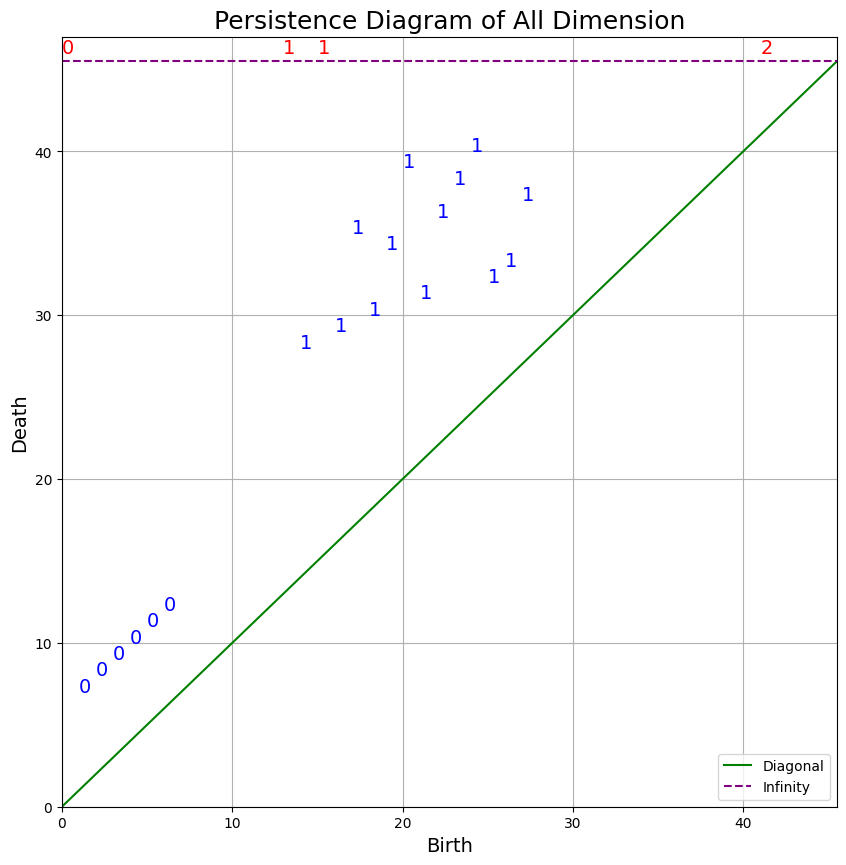

In [51]:
plot_persistence_diagram_all_dimension(sc_1)